In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pd.set_option('display.max_rows', None)  # display all rows.
pd.set_option('display.float_format', '{:.2f}'.format)  # two decimals.

%matplotlib inline

In [3]:
def get_all_data(method):
    data = pd.DataFrame()
    
    for experiment in range(1, 73):
        df = pd.read_csv(f"cache/{experiment}-{method}.csv")
        df["experiment"] = experiment
        
        data = data.append(df, ignore_index=True)

    return data.set_index(["experiment", "instance"])

In [4]:
heuristic = get_all_data("heuristic")
heuristic.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4774.84                       611   
           2           4759.64                       606   
           3           4640.12                       611   
           4           4680.35                       588   
           5           4701.76                       611   

                     self-study (# learners)  activities (#)  
experiment instance                                           
1          1                             189              43  
           2                             194              43  
           3                             189              43  
           4                             212              43  
           5                             189              43

In [5]:
ilp = get_all_data("ilp")
ilp.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4777.54                       611   
           2           4765.53                       608   
           3           4644.67                       613   
           4           4690.98                       590   
           5           4709.46                       616   

                     self-study (# learners)  activities (#)  
experiment instance                                           
1          1                             189              43  
           2                             192              43  
           3                             187              43  
           4                             210              43  
           5                             184              43

# Objectives

In [6]:
objectives = pd.DataFrame(index=heuristic.index)

objectives["ilp"] = ilp.objective
objectives["heuristic"] = heuristic.objective
objectives["percentage"] = 100 * (ilp.objective - heuristic.objective) / heuristic.objective

grouped = objectives.groupby("experiment")

Text(0, 0.5, 'Experiments (#)')

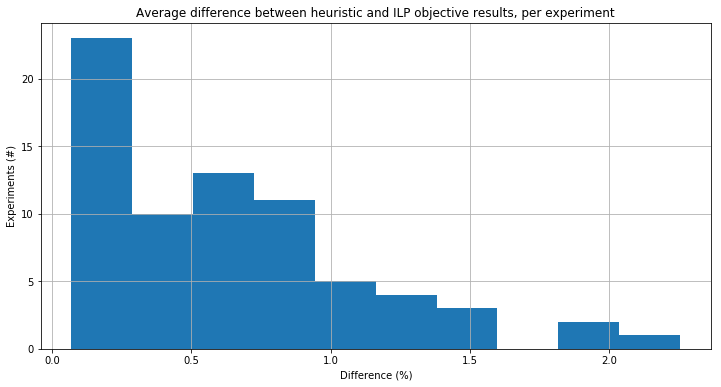

In [7]:
grouped.percentage.mean().hist(figsize=(12, 6))
plt.title("Average difference between heuristic and ILP objective results, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

Text(0, 0.5, 'Experiments (#)')

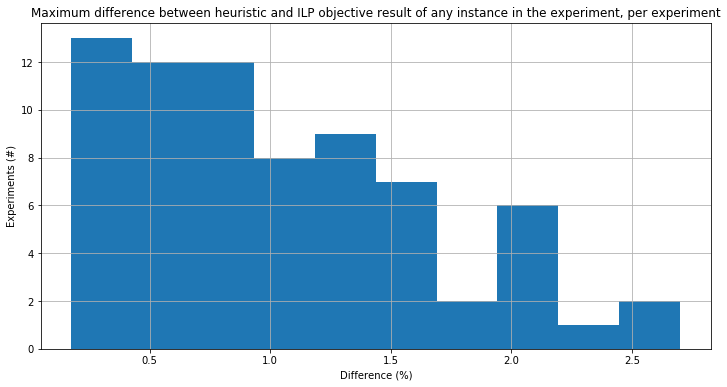

In [8]:
grouped.percentage.max().hist(figsize=(12, 6))
plt.title("Maximum difference between heuristic and ILP objective result of any instance in the experiment, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

In [9]:
aggregates = grouped.aggregate({"ilp": "mean", "heuristic": "mean", "percentage": ["mean", "max"]})
print(aggregates.to_latex(longtable=True, label="tab:heuristic_performance"))

\begin{longtable}{lrrrr}
\label{tab:heuristic_performance}\\
\toprule
{} &     ilp & heuristic & \multicolumn{2}{l}{percentage} \\
{} &    mean &      mean &       mean &  max \\
experiment &         &           &            &      \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1          & 4726.15 &   4719.89 &       0.13 & 0.32 \\
2          & 4717.15 &   4711.47 &       0.12 & 0.27 \\
3          & 4720.07 &   4714.77 &       0.11 & 0.29 \\
4          & 4845.05 &   4835.82 &       0.19 & 0.32 \\
5          & 4853.04 &   4843.85 &       0.19 & 0.36 \\
6          & 4800.44 &   4788.20 &       0.26 & 0.48 \\
7          & 9773.15 &   9765.84 &       0.07 & 0.18 \\
8          & 9751.89 &   9745.08 &       0.07 & 0.19 \\
9          & 9751.20 &   9742.71 &       0.09 & 0.19 \\
10         & 9799.91 &   9741.24 &       0.60 & 0.73 \\
11         & 9781.64 &   9724.06 &       0.59 & 0.76 \\
12         & 9702.68 &   9639.

# Policies

In [10]:
experiments = pd.read_excel("../experiments/experiments.xlsx")

data = ilp.join(experiments, on="experiment")
data.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4777.54                       611   
           2           4765.53                       608   
           3           4644.67                       613   
           4           4690.98                       590   
           5           4709.46                       616   

                     self-study (# learners)  activities (#)  experiment  \
experiment instance                                                        
1          1                             189              43        2.00   
           2                             192              43        2.00   
           3                             187              43        2.00   
           4                             210              43        2.00   
           5                             184              43        2.00   

                     penalty  progress  learners  instruction_classrooms  \
experiment instance                                                        
1          1            1.00      0.00    800.00                   40.00   
           2            1.00      0.00    800.00                   40.00   
           3            1.00      0.00    800.00                   40.00   
           4            1.00      0.00    800.00                   40.00   
           5            1.00      0.00    800.00                   40.00   

                     instruction_size  self_study_classrooms  self_study_size  \
experiment instance                                                             
1          1                    32.00                   3.00            80.00   
           2                    32.00                   3.00            80.00   
           3                    32.00                   3.00            80.00   
           4                    32.00                   3.00            80.00   
           5                    32.00                   3.00            80.00   

                     num_teachers  first_degree  second_degree  third_degree  
experiment instance                                                           
1          1                80.00          0.50           0.50          0.00  
           2                80.00          0.50           0.50          0.00  
           3                80.00          0.50           0.50          0.00  
           4                80.00          0.50           0.50          0.00  
           5                80.00          0.50           0.50          0.00

In [11]:
grouped = data.groupby(["learners", "progress"])
grouped["self-study (# learners)"].mean()

learners  progress
800.00    0.00       129.62
          1.00       378.78
          2.00       515.82
1600.00   0.00        89.07
          1.00       453.80
          2.00       691.74
Name: self-study (# learners), dtype: float64

In [12]:
# First degree codes all relevant information:
# - 1.00 == (1, 0, 0)
# - 0.50 == (.5, .5, 0)
# - 0.40 == (0.4, 0.4, 0.2)
grouped = data.groupby(["learners", "first_degree"])
grouped["self-study (# learners)"].mean()

learners  first_degree
800.00    0.40           335.57
          0.50           330.58
          1.00           378.68
1600.00   0.40           410.24
          0.50           408.96
          1.00           415.41
Name: self-study (# learners), dtype: float64

In [15]:
grouped = data.groupby(["learners", "penalty"])
grouped["self-study (# learners)"].mean()

learners  penalty
800.00    1.00      365.20
          2.00      330.62
1600.00   1.00      474.24
          2.00      348.83
Name: self-study (# learners), dtype: float64

In [14]:
grouped = data.groupby(["learners", "instruction_size"])
grouped["self-study (# learners)"].mean()

learners  instruction_size
800.00    16.00              316.16
          32.00              380.52
1600.00   16.00              383.98
          32.00              439.09
Name: self-study (# learners), dtype: float64